In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

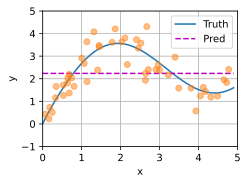

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [6]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
X_repeat.shape
# n_train
X_repeat
x_train.shape

torch.Size([50])

In [7]:
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
attention_weights

tensor([[5.8742e-02, 5.8118e-02, 5.7909e-02,  ..., 1.1701e-06, 8.4631e-07,
         6.6103e-07],
        [5.4974e-02, 5.4898e-02, 5.4815e-02,  ..., 1.7319e-06, 1.2614e-06,
         9.9037e-07],
        [5.1290e-02, 5.1697e-02, 5.1727e-02,  ..., 2.5557e-06, 1.8743e-06,
         1.4793e-06],
        ...,
        [1.8834e-06, 2.8828e-06, 3.1699e-06,  ..., 8.5600e-02, 8.5672e-02,
         8.5457e-02],
        [1.2661e-06, 1.9561e-06, 2.1554e-06,  ..., 9.1019e-02, 9.1727e-02,
         9.1974e-02],
        [8.4757e-07, 1.3217e-06, 1.4594e-06,  ..., 9.6369e-02, 9.7793e-02,
         9.8568e-02]])

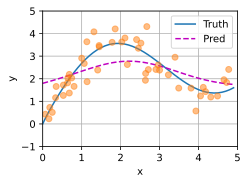

In [8]:
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [9]:
attention_weights.shape

torch.Size([50, 50])

In [10]:
y_train.shape

torch.Size([50])

In [11]:
y_hat.shape

torch.Size([50])

In [12]:
a=torch.arange(9).reshape(3,3)

In [13]:
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [14]:
b=torch.Tensor([1,2,3]).long()

In [28]:
torch.matmul(a,b)

tensor([ 8, 26, 44])

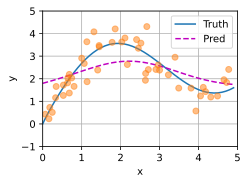

In [15]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

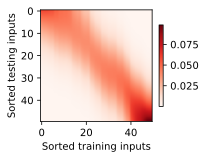

In [16]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [17]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [18]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [19]:
weights

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])

In [20]:
values

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]])

In [21]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [22]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [26]:
X_tile

tensor([[0.0685, 0.1613, 0.1823,  ..., 4.6532, 4.7223, 4.7744],
        [0.0685, 0.1613, 0.1823,  ..., 4.6532, 4.7223, 4.7744],
        [0.0685, 0.1613, 0.1823,  ..., 4.6532, 4.7223, 4.7744],
        ...,
        [0.0685, 0.1613, 0.1823,  ..., 4.6532, 4.7223, 4.7744],
        [0.0685, 0.1613, 0.1823,  ..., 4.6532, 4.7223, 4.7744],
        [0.0685, 0.1613, 0.1823,  ..., 4.6532, 4.7223, 4.7744]])

In [30]:
keys

tensor([[0.1613, 0.1823, 0.2463,  ..., 4.6532, 4.7223, 4.7744],
        [0.0685, 0.1823, 0.2463,  ..., 4.6532, 4.7223, 4.7744],
        [0.0685, 0.1613, 0.2463,  ..., 4.6532, 4.7223, 4.7744],
        ...,
        [0.0685, 0.1613, 0.1823,  ..., 4.4885, 4.7223, 4.7744],
        [0.0685, 0.1613, 0.1823,  ..., 4.4885, 4.6532, 4.7744],
        [0.0685, 0.1613, 0.1823,  ..., 4.4885, 4.6532, 4.7223]])

In [31]:
Y_tile

tensor([[0.4298, 0.2295, 0.7304,  ..., 1.9572, 1.8352, 2.4125],
        [0.4298, 0.2295, 0.7304,  ..., 1.9572, 1.8352, 2.4125],
        [0.4298, 0.2295, 0.7304,  ..., 1.9572, 1.8352, 2.4125],
        ...,
        [0.4298, 0.2295, 0.7304,  ..., 1.9572, 1.8352, 2.4125],
        [0.4298, 0.2295, 0.7304,  ..., 1.9572, 1.8352, 2.4125],
        [0.4298, 0.2295, 0.7304,  ..., 1.9572, 1.8352, 2.4125]])

In [32]:
values

tensor([[0.2295, 0.7304, 0.5123,  ..., 1.9572, 1.8352, 2.4125],
        [0.4298, 0.7304, 0.5123,  ..., 1.9572, 1.8352, 2.4125],
        [0.4298, 0.2295, 0.5123,  ..., 1.9572, 1.8352, 2.4125],
        ...,
        [0.4298, 0.2295, 0.7304,  ..., 1.2353, 1.8352, 2.4125],
        [0.4298, 0.2295, 0.7304,  ..., 1.2353, 1.9572, 2.4125],
        [0.4298, 0.2295, 0.7304,  ..., 1.2353, 1.9572, 1.8352]])

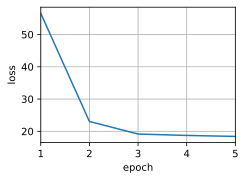

In [35]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

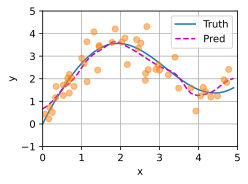

In [36]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

In [37]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [38]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [39]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4037, 0.5963, 0.0000, 0.0000],
         [0.3223, 0.6777, 0.0000, 0.0000]],

        [[0.5036, 0.2899, 0.2065, 0.0000],
         [0.5348, 0.2331, 0.2321, 0.0000]]])

In [40]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3652, 0.3351, 0.2997, 0.0000]],

        [[0.4571, 0.5429, 0.0000, 0.0000],
         [0.3587, 0.2579, 0.1822, 0.2013]]])

In [41]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [42]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
a=attention(queries, keys, values, valid_lens)

In [43]:
a.shape

torch.Size([2, 1, 4])

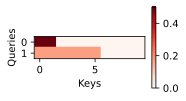

In [44]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [45]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [46]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

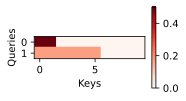

In [47]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')